## Baseline CNN Model

This notebook provides a **baseline Convolutional Neural Network (CNN)** implementation.  
It is intended to serve as a **reference and guideline** for developing and experimenting with new CNN architectures.  

Important:  
- This notebook should remain unchanged to preserve the baseline implementation.  
- For modifications, please **duplicate** this notebook and use the copy for experimentation and model development.  


In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

# Project modules
from utils import *
from utils_visualisation import *
from Data_Handler import ClimbingDataset
from models import *
from trainer import *

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchmetrics.classification import MulticlassAccuracy
from torchinfo import summary


# Image filters
import kornia.filters as KF




/home/fillies/Documents/moon/kilter/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Hyperparameter:

blur_kernel_size = 3 
blur_sigma = 1.0
batch_size = 32
hidden_units_CNN = 16
hidden_units_classifier = 16
lr = 1e-4
weight_decay = 1e-4




In [3]:



transform = KF.GaussianBlur2d(kernel_size=(blur_kernel_size, blur_kernel_size), sigma=(blur_sigma, blur_sigma), border_type="constant")

climbing_DB = ClimbingDataset(board_names=["12 x 12 with kickboard Square"],#, "8 x 12 Home"],
                            map=True, 
                            transform=transform,
                            label_filter=[5, 14],
                            max_samples=12000 
)
num_classes = climbing_DB.num_classes
num_features = climbing_DB.num_features

print(f"Number of classes: {num_classes}")
print(f"Number of features: {num_features}")

Number of classes: 21
Number of features: 4


Number of Datapoints: 4472
Singe X shape: torch.Size([4, 35, 35]), Single y shape: torch.Size([21])


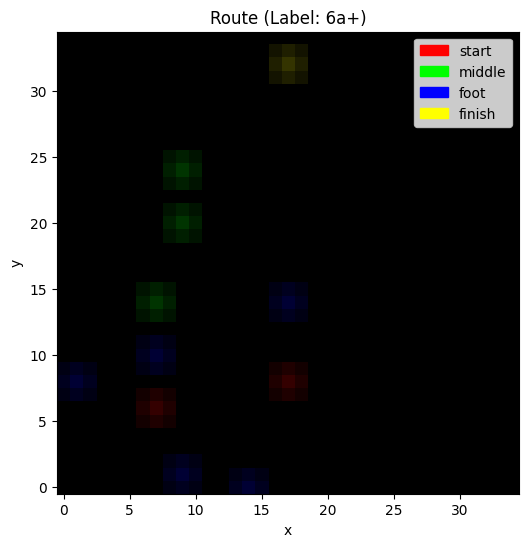

In [4]:
print(f"Number of Datapoints: {len(climbing_DB)}")

X, y = climbing_DB[15]

print(f"Singe X shape: {X.shape}, Single y shape: {y.shape}")
plot_route(X, torch.argmax(y))



In [5]:

train_size = int(0.8 * len(climbing_DB))  # 80% train
test_size = len(climbing_DB) - train_size

# Deterministic split (set generator seed for reproducibility)
train_dataset, test_dataset = random_split(
    climbing_DB,
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Wrap in DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")





Train samples: 3577, Test samples: 895


Approx dataset tensor size: 88.026848 MB
Train distribution:
  Class 6a+: 1523.0 (42.6%)
  Class 7c: 2054.0 (57.4%)

Test distribution:
  Class 6a+: 379.0 (42.3%)
  Class 7c: 516.0 (57.7%)


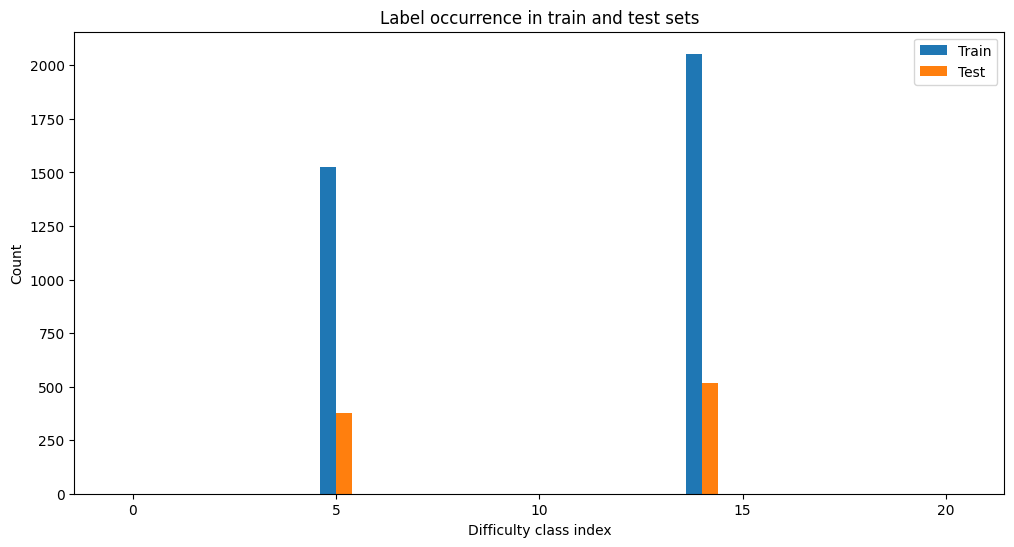

In [6]:
# Some visualisations and Data demand: 
total_bytes = 0
for data, target in train_dataset:
    if isinstance(data, torch.Tensor):
        total_bytes += data.element_size() * data.nelement()
    if isinstance(target, torch.Tensor):
        total_bytes += target.element_size() * target.nelement()
        
for data, target in test_dataset:
    if isinstance(data, torch.Tensor):
        total_bytes += data.element_size() * data.nelement()
    if isinstance(target, torch.Tensor):
        total_bytes += target.element_size() * target.nelement()
        
print("Approx dataset tensor size:", total_bytes / 1e6, "MB")

#

#print(measure_loader_time(train_loader, num_batches=200))
#print_hold_statistics(train_dataset, num_classes=climbing_DB.num_classes )
plot_label_distribution(train_dataset, test_dataset, num_classes=climbing_DB.num_classes)




In [7]:
torch.__version__
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [8]:
loss_fn = torch.nn.CrossEntropyLoss()
acc_fn = Multiclass_accuracy()# MulticlassAccuracy(num_classes=num_classes).to(device)



shallow_model = shallowCNN(input_shape= num_features,
                     hidden_units_CNN= hidden_units_CNN, 
                     hidden_units_classifier=  hidden_units_classifier, 
                     output_shape=num_classes 
                     ).to(device)
optimizer_shallow = optim.Adam(shallow_model.parameters(), lr=lr, weight_decay=weight_decay) 



summary(model=shallow_model, input_size=(1, 4, 35, 35))



Layer (type:depth-idx)                   Output Shape              Param #
shallowCNN                               [1, 21]                   --
├─Sequential: 1-1                        [1, 16, 35, 35]           --
│    └─Conv2d: 2-1                       [1, 16, 35, 35]           592
│    └─ReLU: 2-2                         [1, 16, 35, 35]           --
│    └─BatchNorm2d: 2-3                  [1, 16, 35, 35]           32
│    └─Conv2d: 2-4                       [1, 16, 35, 35]           2,320
│    └─ReLU: 2-5                         [1, 16, 35, 35]           --
│    └─BatchNorm2d: 2-6                  [1, 16, 35, 35]           32
├─Sequential: 1-2                        [1, 21]                   --
│    └─AdaptiveAvgPool2d: 2-7            [1, 16, 1, 1]             --
│    └─Flatten: 2-8                      [1, 16]                   --
│    └─Linear: 2-9                       [1, 16]                   272
│    └─ReLU: 2-10                        [1, 16]                   --
│    └─Dro

In [9]:
trained_model, history = train_model(
        model=shallow_model,
        train_loader=train_loader,
        test_loader=test_loader,
        loss_fn=loss_fn,
        optimizer=optimizer_shallow,
        acc_fn=acc_fn,
        device=device,
        epochs=100,      # you can change this
        patience=15    # early stopping patience
    )

/home/fillies/Documents/moon/kilter/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Epoch 0000 | Train loss: 2.82746 | Train acc: 0.42565 | Test loss: 2.79967 | Test acc: 0.42339
Timing: total 3.225 s | train 2.546 s | eval 0.679 s

Epoch 0001 | Train loss: 2.76334 | Train acc: 0.42596 | Test loss: 2.72918 | Test acc: 0.42339
Timing: total 3.129 s | train 2.615 s | eval 0.513 s

Epoch 0002 | Train loss: 2.67566 | Train acc: 0.42533 | Test loss: 2.60879 | Test acc: 0.42339
Timing: total 3.755 s | train 2.807 s | eval 0.948 s

Epoch 0003 | Train loss: 2.54533 | Train acc: 0.42596 | Test loss: 2.46160 | Test acc: 0.42339
Timing: total 7.130 s | train 6.196 s | eval 0.933 s

Epoch 0004 | Train loss: 2.33731 | Train acc: 0.42580 | Test loss: 2.13511 | Test acc: 0.42339
Timing: total 6.479 s | train 5.615 s | eval 0.864 s

Epoch 0005 | Train loss: 2.02662 | Train acc: 0.42588 | Test loss: 1.89231 | Test acc: 0.42339
Timing: total 6.737 s | train 5.838 s | eval 0.899 s

Epoch 0006 | Train loss: 1.64978 | Train acc: 0.42549 | Test loss: 1.47152 | Test acc: 0.42339
Timing: to


📊 Distributions for shallowCNN:
True labels:
  Class 5: 379 (42.3%)
  Class 14: 516 (57.7%)

Predicted labels:
  Class 5: 214 (23.9%)
  Class 14: 681 (76.1%)

✅ Accuracy (overall): 79.55% (712/895)
ℹ️  Accuracy via acc_fn (avg over batches): 79.56%


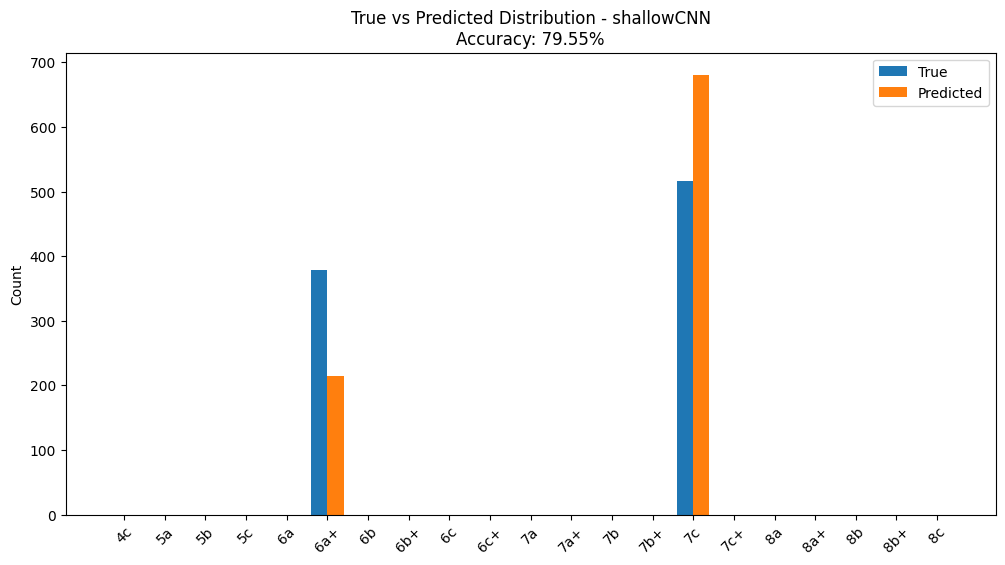

In [10]:
plot_prediction_distribution(
        model=shallow_model,
        test_loader=test_loader,
        num_classes=num_classes,
        model_name=shallow_model.__class__.__name__,
        acc_fn=acc_fn,
        device=device
    )

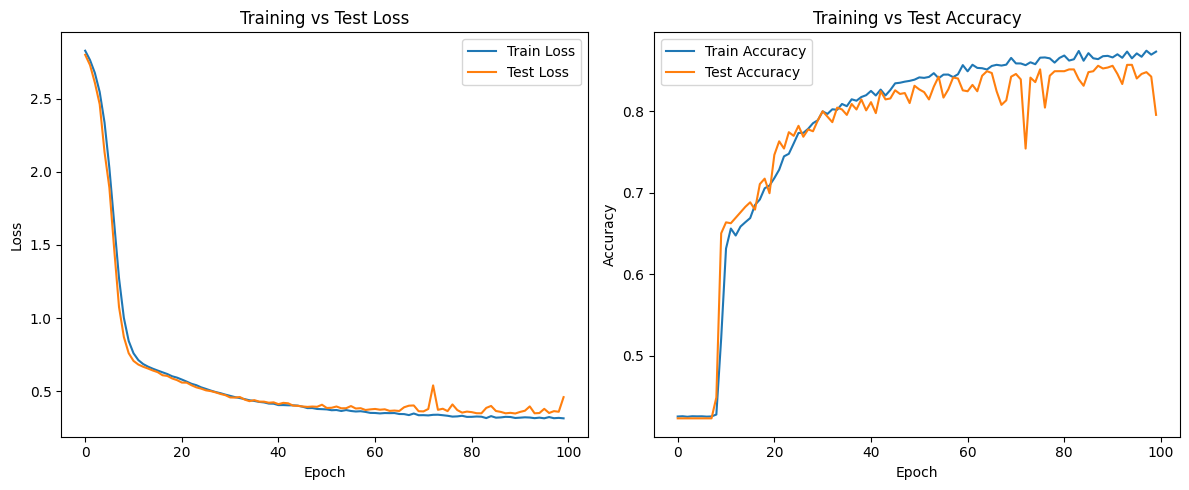

In [11]:
plot_training_history(history)